# Frame the Problem

### Story
The United Kingdom government wants to devote a large portion of funding towards suprressing vehicular accidents. Before they go through with this proposed funding, they want to identify trends in the accident reports to find spots of high accidental occurence. The funding will be used to fix the roads and/or create new, safer road designs.

1. Define the objective in business terms. 
    - Utilizing the United Kingdom vehicle related accidents dataset, we want to identify causes of accidents for different areas in the UK and determine what spots should the funding be focused to.
2. How will your solution be used? 
    - Hopefully, by figuring out the locations of high accidents and also determine their causes, we will able to rationalize the funding.
3. What are the current solutions/workarounds (if any)? 
    - None
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    - This will be a supervised, classification offline learning problem.
5. How should performance be measured? Is the performance measure aligned with the business objective?
    - To not waste fundings, we would want to be as accurate as possible as this proposal was created in the intent to save lives. Therefore we would want to use precision.
6. What would be the minimum performance needed to reach the business objective? 
    - Because we want to be extremely accurate, we want to aim for the best performance possible. Based on the score will determine whether or not the funding should be dispersed.
7. What are comparable problems? Can you reuse experience or tools?
    - A similar problem would be the bike sharing problem where there was a similar design in the "hot spots" and it being a supervised classification itself.
8. Is human expertise available?
    - No
9. How would you solve the problem manually?
    - I would try and find trends of accidents at specific spots. Perhaps this spot at this time is more prone to there being accidents, maybe this spot has a bad blind spot for vehicles causing more civilian death. I would leave out consumer related information such as the type of vehicles, however still would check to see if specific cause more accidents at certain spots (maybe super cars on highways?). I would also try and see trends in the person information, perhaps deduce whether new laws should be constructed for older drivers to be reexamined. I would also leave out unnecessary data like resulting police force.
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible.
    - I assume that weather would be a cause for higher deaths and also time frames for rush hour. I also assume living types such as rural vs city would be much different. Highways would have much more severe accidents.



# Get the Data

In [1]:
import numpy as np
import scipy.sparse
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
def load_data():
    """
    Loads the data from the CSV files.
    """
    
    accidents = pd.read_csv('Accidents0514.csv')
    casualties = pd.read_csv('Casualties0514.csv')
    vehicles = pd.read_csv('Vehicles0514.csv')

    combined = pd.merge(accidents, casualties, on='Accident_Index')
    combined = pd.merge(combined, vehicles, on='Accident_Index')

    # turn combined time object into float
    combined.dropna(subset=['Time'],axis=0,inplace=True)
    combined['Time_Num'] = combined['Time'].astype(str)
    combined['Time_Num'] = combined['Time_Num'].str.replace(':', '')
    combined['Time_Num'] = combined['Time_Num'].astype(float)

    # column for hour and column for every ten minutes
    combined['Hour'] = combined['Time_Num'] // 100
    combined['Minute'] = combined['Time_Num'] % 100

    # convert data to datetimelike values
    combined['Date'] = pd.to_datetime(combined['Date'])

    # column for day of week
    combined['Day_of_Week'] = combined['Date'].dt.dayofweek

    # # column for month
    combined['Month'] = combined['Date'].dt.month

    # # column for year
    combined['Year'] = combined['Date'].dt.year

    # # column for month and year
    combined['Month_Year'] = combined['Date'].dt.strftime('%m%Y')

    # # column for day of week and month
    combined['Day_of_Week_Month'] = combined['Date'].dt.strftime('%w%m')

    # # column for time of day and day of week
    combined['Time_of_Day_Day_of_Week'] = combined['Date'].dt.strftime('%H%w')

    return combined

class NumpyArrayToPandasDataFrame(BaseEstimator, TransformerMixin):
    """
    This class takes a numpy array as well as a list of indexes and column names to transform 
    a numpy array back into a pandas dataframe during within a pipeline.
    """
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        self.indexes = X.index
        self.columns = X.columns
        X_new = self.transformer.transform(X)

        if not isinstance(X_new, pd.DataFrame):
            return pd.DataFrame(X_new, index=self.indexes[:X.shape[0]], columns=self.columns[:X.shape[1]])
        else:
            self.indexes = X.index
            self.columns = X.columns
            return X

def split_labels(data, label_feature):
    """
    Split the given column of of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]

class DropNaNs(BaseEstimator, TransformerMixin):
    """
    This class drops all rows with NaN values.
    """
    def __init__(self, attr):
        super().__init__()
        self.attr = attr

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X):
        for a in self.attr:
            X = X.drop(index=X[X[a] == np.nan].index)
        return X

class RemoveNegatives(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X):
        for a in self.attr:
            X = X.drop(index=X[X[a] < 0].index)
        return X

In [3]:
combined = load_data()

/var/folders/ns/jhsc1w3d101cp62xgg0jvvg00000gn/T/ipykernel_41914/706263969.py:1: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  combined = load_data()


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
combined

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Vehicle_Reference_y,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Time_Num,Hour,Minute,Month,Year,Month_Year,Day_of_Week_Month,Time_of_Day_Day_of_Week
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,2005-04-01,4,17:42,12,E09000020,3,3218,6,30,0,-1,-1,0,0,1,1,2,2,0,0,1,1,E01002849,1,1,3,1,37,7,2,1,1,0,0,-1,0,1,1,9,0,18,0,0,0,0,0,0,1,1,15,2,74,10,-1,-1,-1,7,1,1742.0,17.0,42.0,4,2005,042005,504,005
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,2005-05-01,6,17:36,12,E09000020,4,450,3,30,6,2,5,0,0,5,4,1,1,0,0,1,1,E01002909,1,1,2,1,37,7,3,0,0,0,4,-1,11,1,1,11,0,4,0,3,0,0,0,0,4,1,1,1,42,7,8268,2,3,-1,-1,1736.0,17.0,36.0,5,2005,052005,005,000
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,2005-06-01,2,00:15,12,E09000020,5,0,6,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,E01002857,2,1,1,1,62,9,3,0,0,0,0,-1,9,1,1,11,0,17,0,0,0,4,0,0,4,1,1,1,35,6,8300,2,5,2,1,15.0,0.0,15.0,6,2005,062005,306,003
3,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,2005-06-01,2,00:15,12,E09000020,5,0,6,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,E01002857,2,1,1,1,62,9,3,0,0,0,0,-1,9,1,2,9,0,2,0,0,0,0,0,0,3,1,15,1,62,9,1762,1,6,1,1,15.0,0.0,15.0,6,2005,062005,306,003
4,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,2005-07-01,4,10:35,12,E09000020,3,3220,6,30,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01002840,1,1,3,1,30,6,3,5,2,0,0,-1,0,1,1,9,0,18,0,0,0,0,0,0,1,1,15,2,49,8,1769,1,4,2,1,1035.0,10.0,35.0,7,2005,072005,507,005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4287588,2014984138414,323869.0,566853.0,-3.191397,54.990446,98,2,3,2,2014-12-17,2,06:55,917,S12000006,3,75,6,60,3,4,5,43,0,0,6,2,2,0,0,2,1,NaN,2,2,1,1,44,7,2,0,0,0,0,0,19,1,3,9,0,18,0,2,1,4,1,0,3,1,6,1,73,10,2143,2,-1,8,3,655.0,6.0,55.0,12,2014,122014,312,003
4287589,2014984139614,314072.0,579971.0,-3.348426,55.106700,98,3,2,2,2014-12-24,2,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN,1,2,2,1,61,9,3,0,0,0,4,0,11,2,1,11,0,9,0,8,0,0,0,0,3,1,1,1,40,7,4500,2,4,-1,3,1500.0,15.0,0.0,12,2014,122014,312,003
4287590,2014984139614,314072.0,579971.0,-3.348426,55.106700,98,3,2,2,2014-12-24,2,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN,1,2,2,1,61,9,3,0,0,0,4,0,11,2,2,9,0,18,0,1,0,0,0,0,1,1,6,1,79,11,1398,2,11,-1,3,1500.0,15.0,0.0,12,2014,122014,312,003
4287591,2014984139614,314072.0,579971.0,-3.348426,55.106700,98,3,2,2,2014-12-24,2,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN,2,1,1,1,79,11,3,0,0,0,0,0,9,3,1,11,0,9,0,8,0,0,0,0

In [6]:
# """
# The accident file provide detailed about the circumstances of an accident from 2005 to 2014 such as weather, location lat/long, area type, road type,date, time, day of week and much more…
# The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
# All the data variables are coded rather than containing textual strings.
# The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table.
# """

# # drop irrelevant features
# accidents.drop('LSOA_of_Accident_Location', axis=1, inplace=True)
# accidents.drop('Did_Police_Officer_Attend_Scene_of_Accident', axis=1, inplace=True)
# accidents.drop('Carriageway_Hazards', axis=1, inplace=True)
# accidents.drop('Location_Easting_OSGR', axis=1, inplace=True)
# accidents.drop('Location_Northing_OSGR', axis=1, inplace=True)
# accidents.drop('Police_Force', axis=1, inplace=True)
# accidents.drop('Local_Authority_(District)', axis=1, inplace=True)
# accidents.drop('Local_Authority_(Highway)', axis=1, inplace=True)
# accidents.drop('1st_Road_Class', axis=1, inplace=True)
# accidents.drop('1st_Road_Number', axis=1, inplace=True)
# accidents.drop('2nd_Road_Class', axis=1, inplace=True)
# accidents.drop('2nd_Road_Number', axis=1, inplace=True)
# accidents.drop('Pedestrian_Crossing-Human_Control', axis=1, inplace=True)
# accidents.drop('Pedestrian_Crossing-Physical_Facilities', axis=1, inplace=True)
# accidents.drop('Special_Conditions_at_Site', axis=1, inplace=True)
# accidents.drop('Number_of_Vehicles', axis=1, inplace=True)
# accidents.drop('Number_of_Casualties', axis=1, inplace=True)



In [6]:
"""
The accident file provide detailed about the circumstances of an accident from 2005 to 2014 such as weather, location lat/long, area type, road type,date, time, day of week and much more…
The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
All the data variables are coded rather than containing textual strings.
The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table.
"""

combined_reduced = combined.copy()

# drop irrelevant features
combined_reduced.drop('LSOA_of_Accident_Location', axis=1, inplace=True)
combined_reduced.drop('Did_Police_Officer_Attend_Scene_of_Accident', axis=1, inplace=True)
combined_reduced.drop('Carriageway_Hazards', axis=1, inplace=True)
combined_reduced.drop('Location_Easting_OSGR', axis=1, inplace=True)
combined_reduced.drop('Location_Northing_OSGR', axis=1, inplace=True)
combined_reduced.drop('Police_Force', axis=1, inplace=True)
combined_reduced.drop('Local_Authority_(District)', axis=1, inplace=True)
combined_reduced.drop('Local_Authority_(Highway)', axis=1, inplace=True)
combined_reduced.drop('1st_Road_Class', axis=1, inplace=True)
combined_reduced.drop('1st_Road_Number', axis=1, inplace=True)
combined_reduced.drop('2nd_Road_Class', axis=1, inplace=True)
combined_reduced.drop('2nd_Road_Number', axis=1, inplace=True)
combined_reduced.drop('Pedestrian_Crossing-Human_Control', axis=1, inplace=True)
combined_reduced.drop('Pedestrian_Crossing-Physical_Facilities', axis=1, inplace=True)
combined_reduced.drop('Special_Conditions_at_Site', axis=1, inplace=True)
combined_reduced.drop('Number_of_Vehicles', axis=1, inplace=True)
combined_reduced.drop('Number_of_Casualties', axis=1, inplace=True)
combined_reduced.drop('Age_Band_of_Casualty', axis=1, inplace=True)
combined_reduced.drop('Engine_Capacity_(CC)', axis=1, inplace=True)
combined_reduced.drop('Propulsion_Code', axis=1, inplace=True)
combined_reduced.drop('Driver_IMD_Decile', axis=1, inplace=True)
combined_reduced.drop('Towing_and_Articulation', axis=1, inplace=True)
combined_reduced.drop('Journey_Purpose_of_Driver', axis=1, inplace=True)
combined_reduced.drop('Vehicle_Location-Restricted_Lane', axis=1, inplace=True)
combined_reduced.drop('Hit_Object_in_Carriageway', axis=1, inplace=True)
combined_reduced.drop('Vehicle_Leaving_Carriageway', axis=1, inplace=True)
combined_reduced.drop('Age_of_Casualty', axis=1, inplace=True)
combined_reduced.drop('Sex_of_Casualty', axis=1, inplace=True)

In [7]:
combined

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Vehicle_Reference_y,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Time_Num,Hour,Minute,Month,Year,Month_Year,Day_of_Week_Month,Time_of_Day_Day_of_Week
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,2005-04-01,4,17:42,12,E09000020,3,3218,6,30,0,-1,-1,0,0,1,1,2,2,0,0,1,1,E01002849,1,1,3,1,37,7,2,1,1,0,0,-1,0,1,1,9,0,18,0,0,0,0,0,0,1,1,15,2,74,10,-1,-1,-1,7,1,1742.0,17.0,42.0,4,2005,042005,504,005
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,2005-05-01,6,17:36,12,E09000020,4,450,3,30,6,2,5,0,0,5,4,1,1,0,0,1,1,E01002909,1,1,2,1,37,7,3,0,0,0,4,-1,11,1,1,11,0,4,0,3,0,0,0,0,4,1,1,1,42,7,8268,2,3,-1,-1,1736.0,17.0,36.0,5,2005,052005,005,000
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,2005-06-01,2,00:15,12,E09000020,5,0,6,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,E01002857,2,1,1,1,62,9,3,0,0,0,0,-1,9,1,1,11,0,17,0,0,0,4,0,0,4,1,1,1,35,6,8300,2,5,2,1,15.0,0.0,15.0,6,2005,062005,306,003
3,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,2005-06-01,2,00:15,12,E09000020,5,0,6,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,E01002857,2,1,1,1,62,9,3,0,0,0,0,-1,9,1,2,9,0,2,0,0,0,0,0,0,3,1,15,1,62,9,1762,1,6,1,1,15.0,0.0,15.0,6,2005,062005,306,003
4,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,2005-07-01,4,10:35,12,E09000020,3,3220,6,30,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01002840,1,1,3,1,30,6,3,5,2,0,0,-1,0,1,1,9,0,18,0,0,0,0,0,0,1,1,15,2,49,8,1769,1,4,2,1,1035.0,10.0,35.0,7,2005,072005,507,005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4287588,2014984138414,323869.0,566853.0,-3.191397,54.990446,98,2,3,2,2014-12-17,2,06:55,917,S12000006,3,75,6,60,3,4,5,43,0,0,6,2,2,0,0,2,1,NaN,2,2,1,1,44,7,2,0,0,0,0,0,19,1,3,9,0,18,0,2,1,4,1,0,3,1,6,1,73,10,2143,2,-1,8,3,655.0,6.0,55.0,12,2014,122014,312,003
4287589,2014984139614,314072.0,579971.0,-3.348426,55.106700,98,3,2,2,2014-12-24,2,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN,1,2,2,1,61,9,3,0,0,0,4,0,11,2,1,11,0,9,0,8,0,0,0,0,3,1,1,1,40,7,4500,2,4,-1,3,1500.0,15.0,0.0,12,2014,122014,312,003
4287590,2014984139614,314072.0,579971.0,-3.348426,55.106700,98,3,2,2,2014-12-24,2,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN,1,2,2,1,61,9,3,0,0,0,4,0,11,2,2,9,0,18,0,1,0,0,0,0,1,1,6,1,79,11,1398,2,11,-1,3,1500.0,15.0,0.0,12,2014,122014,312,003
4287591,2014984139614,314072.0,579971.0,-3.348426,55.106700,98,3,2,2,2014-12-24,2,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN,2,1,1,1,79,11,3,0,0,0,0,0,9,3,1,11,0,9,0,8,0,0,0,0

In [9]:
"""
The casualties file provide detailed about the circumstances of an accident from 2005 to 2014 such as casualty age, sex, casualty severity, casualty social class, casualty type and much more…
The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
All the data variables are coded rather than containing textual strings.
The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table
"""
# casualties.drop('Age_Band_of_Casualty', axis=1, inplace=True)

# casualties

'\nThe casualties file provide detailed about the circumstances of an accident from 2005 to 2014 such as casualty age, sex, casualty severity, casualty social class, casualty type and much more…\nThe statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.\nAll the data variables are coded rather than containing textual strings.\nThe lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table\n'

In [10]:
"""
The vehicles file provide detailed about the circumstances of an accident from 2005 to 2014 such as vehicle type, age of driver, sex of driver, age of vehicle, engine type, journey purpose and much more…
The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
All the data variables are coded rather than containing textual strings.
The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table.
"""
# vehicles.drop('Engine_Capacity_(CC)', axis=1, inplace=True)
# vehicles.drop('Propulsion_Code', axis=1, inplace=True)
# vehicles.drop('Driver_IMD_Decile', axis=1, inplace=True)
# vehicles.drop('Towing_and_Articulation', axis=1, inplace=True)
# vehicles.drop('Journey_Purpose_of_Driver', axis=1, inplace=True)
# vehicles.drop('Vehicle_Location-Restricted_Lane', axis=1, inplace=True)
# vehicles.drop('Hit_Object_in_Carriageway', axis=1, inplace=True)
# vehicles.drop('Vehicle_Leaving_Carriageway', axis=1, inplace=True)

# vehicles

'\nThe vehicles file provide detailed about the circumstances of an accident from 2005 to 2014 such as vehicle type, age of driver, sex of driver, age of vehicle, engine type, journey purpose and much more…\nThe statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.\nAll the data variables are coded rather than containing textual strings.\nThe lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table.\n'

In [11]:
# Create a combined df after we remove features
# combined = pd.merge(accidents, casualties, on='Accident_Index')
# combined = pd.merge(combined, vehicles, on='Accident_Index')

In [12]:
"""
The lookup file contain all the information to map the coded variables with their textual strings

"""

road_accident_guide = pd.ExcelFile(r'Road-Accident-Safety-Data-Guide.xls')

In [13]:
road_accident_guide.sheet_names

['Introduction',
 'Export Variables',
 'Police Force',
 'Accident Severity',
 'Day of Week',
 'Local Authority (District)',
 'Local Authority (Highway)',
 '1st Road Class',
 'Road Type',
 'Junction Detail',
 'Junction Control',
 '2nd Road Class',
 'Ped Cross - Human',
 'Ped Cross - Physical',
 'Light Conditions',
 'Weather',
 'Road Surface',
 'Special Conditions at Site',
 'Carriageway Hazards',
 'Urban Rural',
 'Police Officer Attend',
 'Vehicle Type',
 'Towing and Articulation',
 'Vehicle Manoeuvre',
 'Vehicle Location',
 'Junction Location',
 'Skidding and Overturning',
 'Hit Object in Carriageway',
 'Veh Leaving Carriageway',
 'Hit Object Off Carriageway',
 '1st Point of Impact',
 'Was Vehicle Left Hand Drive',
 'Journey Purpose',
 'Sex of Driver',
 'Age Band',
 'Vehicle Propulsion Code',
 'Casualty Class',
 'Sex of Casualty',
 'Age of Casualty',
 'Casualty Severity',
 'Ped Location',
 'Ped Movement',
 'Car Passenger',
 'Bus Passenger',
 'Ped Road Maintenance Worker',
 'Casualty Ty

In [14]:

# turn combined time object into float
# combined['Time_Num'] = combined['Time'].astype(str)
# combined['Time_Num'] = combined['Time_Num'].str.replace(':', '')
# combined['Time_Num'] = combined['Time_Num'].astype(float)

In [15]:
# column for hour and column for every ten minutes
# combined['Hour'] = combined['Time_Num'] // 100
# combined['Minute'] = combined['Time_Num'] % 100

In [16]:
# # convert data to datetimelike values
# combined['Date'] = pd.to_datetime(combined['Date'])

# # column for day of week
# combined['Day_of_Week'] = combined['Date'].dt.dayofweek

# # # column for month
# combined['Month'] = combined['Date'].dt.month

# # # column for year
# combined['Year'] = combined['Date'].dt.year

# # # column for month and year
# combined['Month_Year'] = combined['Date'].dt.strftime('%m%Y')

# # # column for day of week and month
# combined['Day_of_Week_Month'] = combined['Date'].dt.strftime('%w%m')

# # # column for time of day and day of week
# combined['Time_of_Day_Day_of_Week'] = combined['Date'].dt.strftime('%H%w')

In [17]:
combined_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4287593 entries, 0 to 4287592
Data columns (total 47 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   Accident_Index                      object        
 1   Longitude                           float64       
 2   Latitude                            float64       
 3   Accident_Severity                   int64         
 4   Date                                datetime64[ns]
 5   Day_of_Week                         int64         
 6   Time                                object        
 7   Road_Type                           int64         
 8   Speed_limit                         int64         
 9   Junction_Detail                     int64         
 10  Junction_Control                    int64         
 11  Light_Conditions                    int64         
 12  Weather_Conditions                  int64         
 13  Road_Surface_Conditions             int64 

In [6]:
X, y = split_labels(combined, 'Urban_or_Rural_Area')
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_valid, X_train = X_train[:50000], X_train[50000:]
y_valid, y_train = y_train[:50000], y_train[50000:]

# Explore the Data

In [19]:
combined_samples = combined_reduced.sample(n=100000, random_state=42)


In [20]:
# make a scatter matrix of all the features in combined_samples
combined_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3732112 to 2158892
Data columns (total 47 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident_Index                      100000 non-null  object        
 1   Longitude                           99991 non-null   float64       
 2   Latitude                            99991 non-null   float64       
 3   Accident_Severity                   100000 non-null  int64         
 4   Date                                100000 non-null  datetime64[ns]
 5   Day_of_Week                         100000 non-null  int64         
 6   Time                                99992 non-null   object        
 7   Road_Type                           100000 non-null  int64         
 8   Speed_limit                         100000 non-null  int64         
 9   Junction_Detail                     100000 non-null  int64         
 10  J

In [21]:
# make a scatter plot of all the features in combined_samples
pd.plotting.scatter_matrix(combined_samples, figsize=(30, 30), s=3, alpha=0.8);

Error in callback <function flush_figures at 0x11d91d670> (for post_execute):


KeyboardInterrupt: 

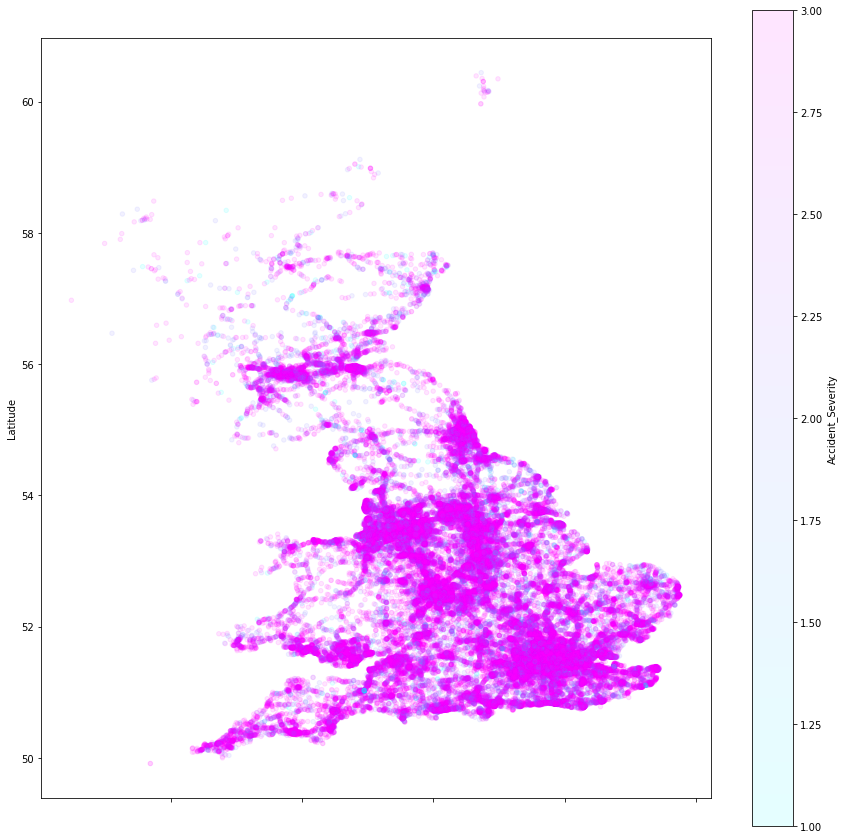

In [ ]:
# View the geographical data based on accident severity (lightblue - high, blurple - mid, purple - low)
# This graph highlights where the low accidents occur
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, c='Accident_Severity' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

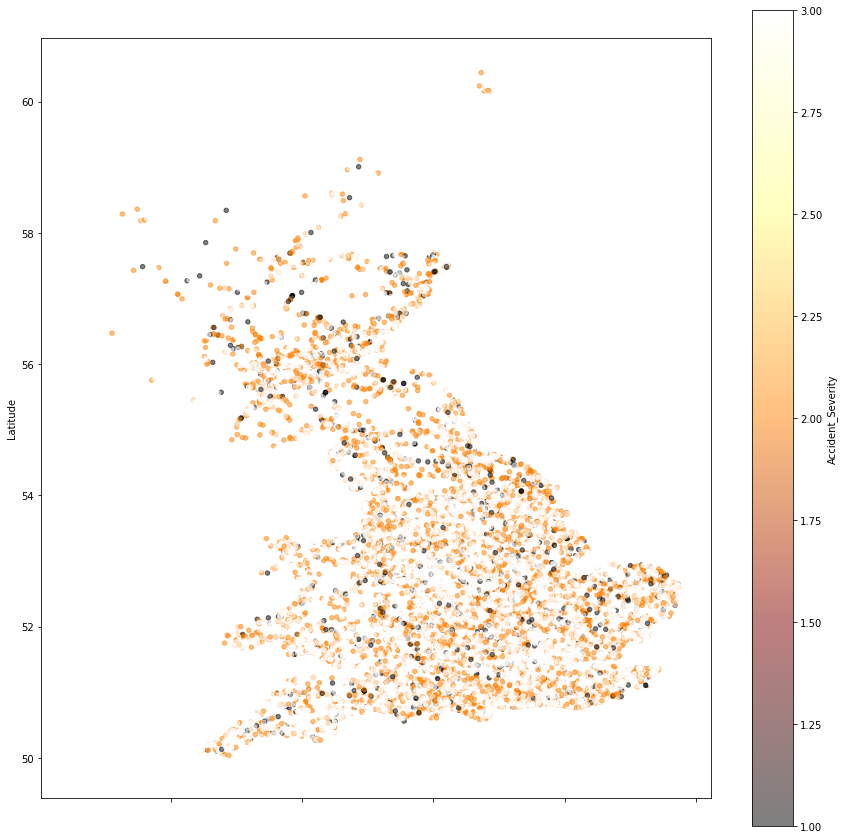

In [ ]:
# View the geographical data based on accident severity (black high, orange - mid, white - low)
# This graph highlights where the high accidents occur (denoted by black dots)
# High accidents aren't as common as low accidents, so it's a good idea to focus on the high accidents
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5, c='Accident_Severity' , cmap='afmhot', figsize=(15,15));
plt.gca().set_aspect('equal')

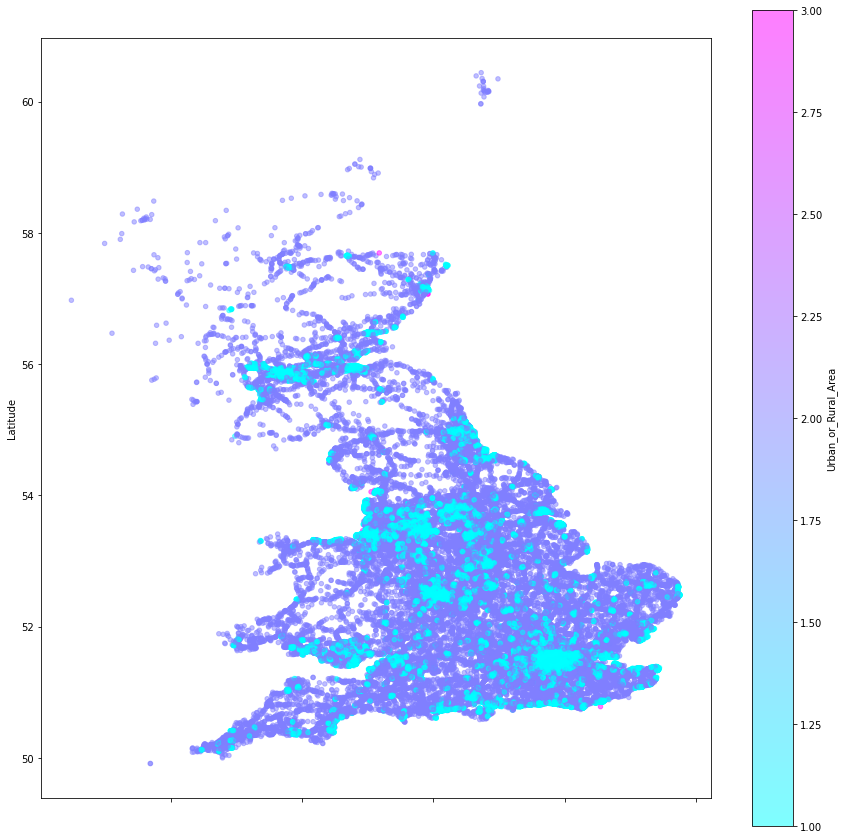

In [ ]:
# View the geographical data based on Area type of the accident (light blue - urban, blueple - rural, purple - unallocated)
# This graph highlights where the urban accidents occur
# Concentration of low accidents occur in the urban areas
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5, c='Urban_or_Rural_Area' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

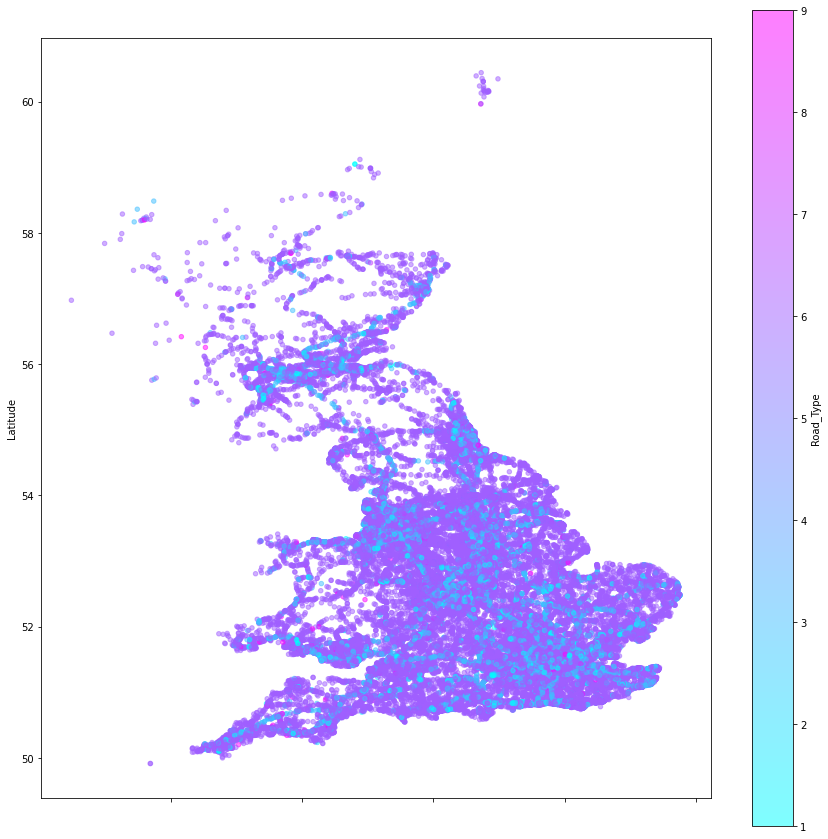

In [ ]:
# View the geographical data based on Area type of the accident (light blue - urban, blueple - rural, purple - unallocated)
# This graph highlights where the urban accidents occur
# Concentration of low accidents occur in the urban areas
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5, c='Road_Type' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

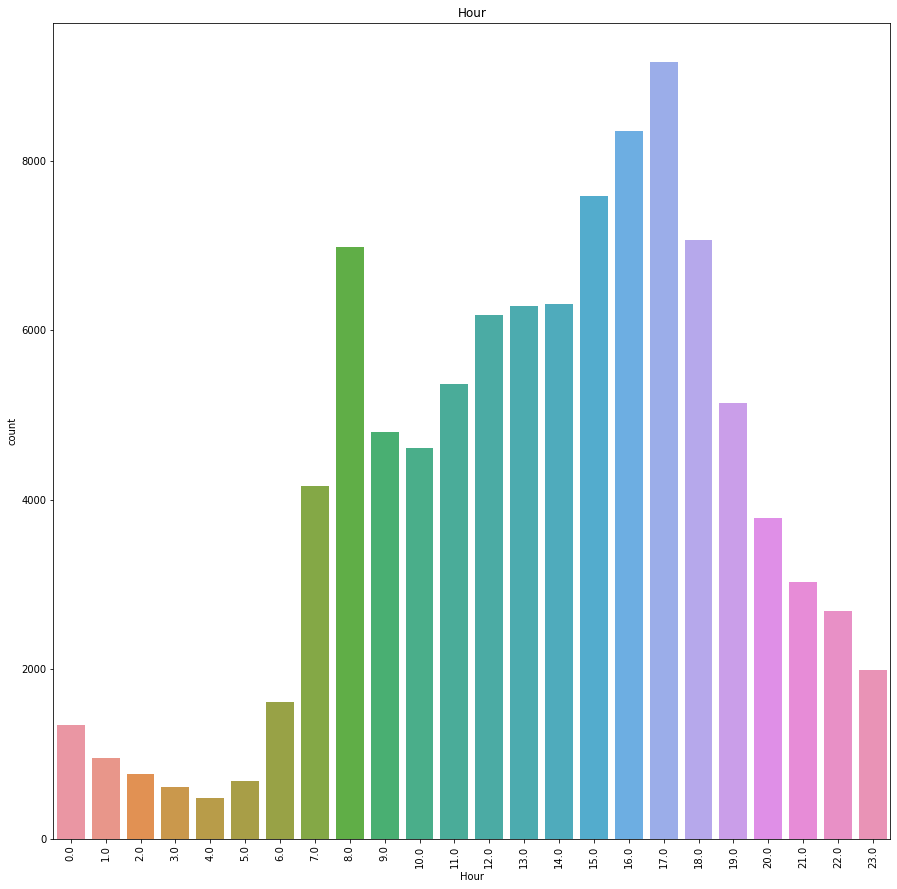

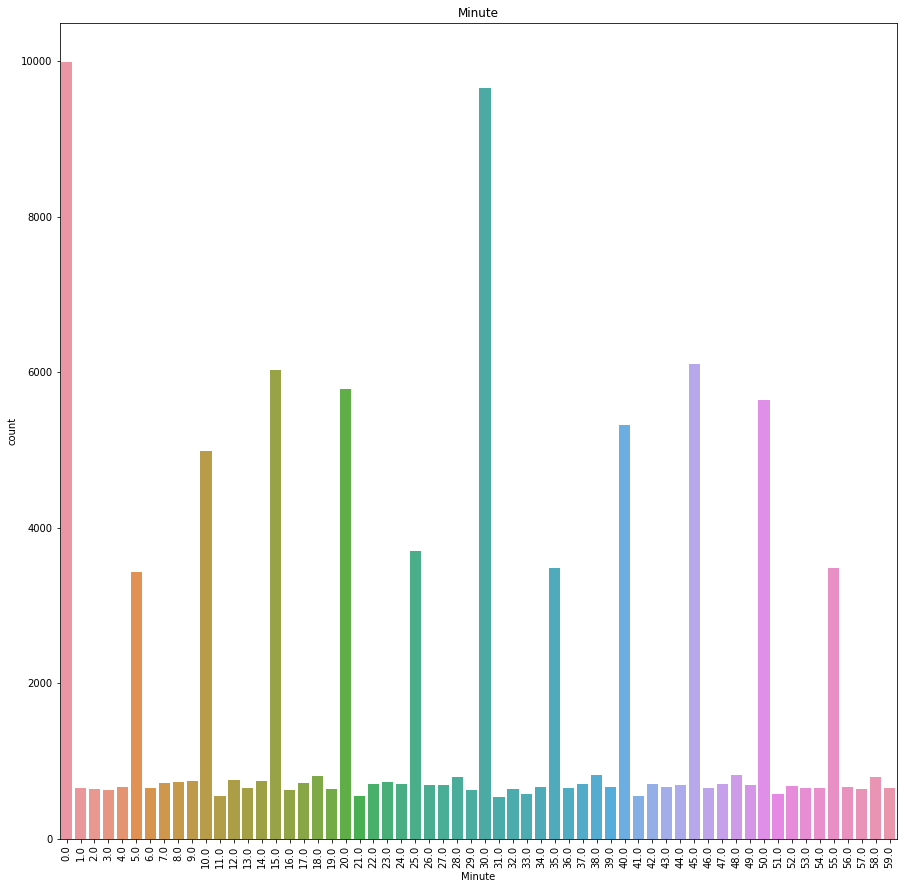

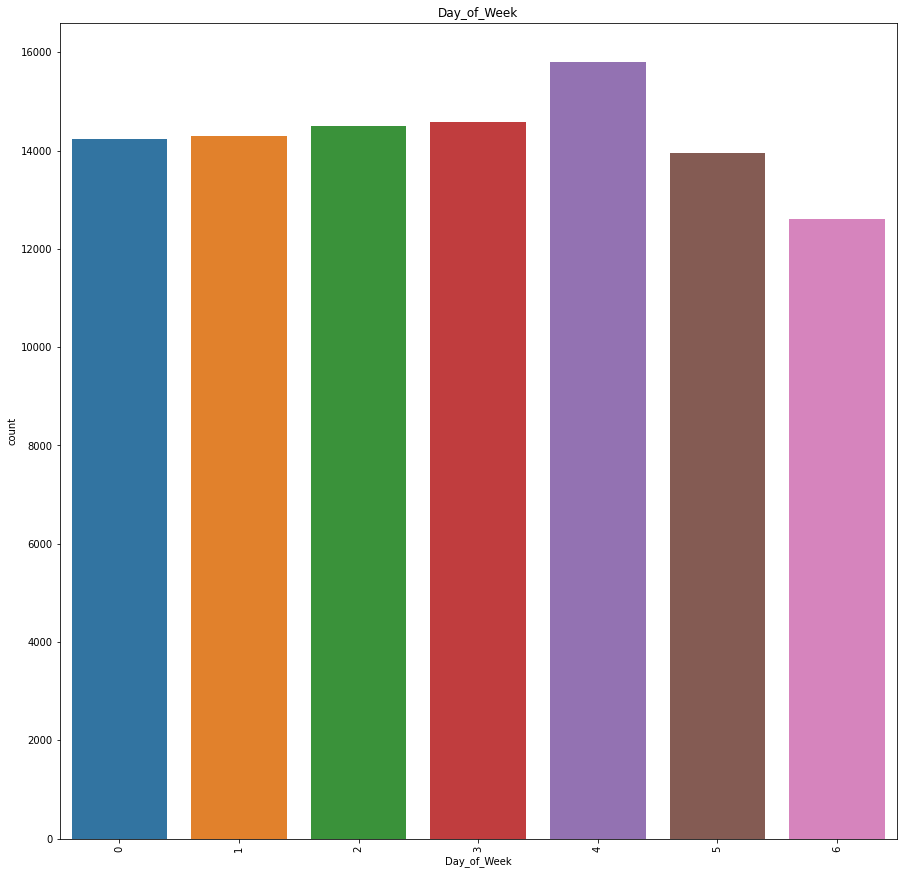

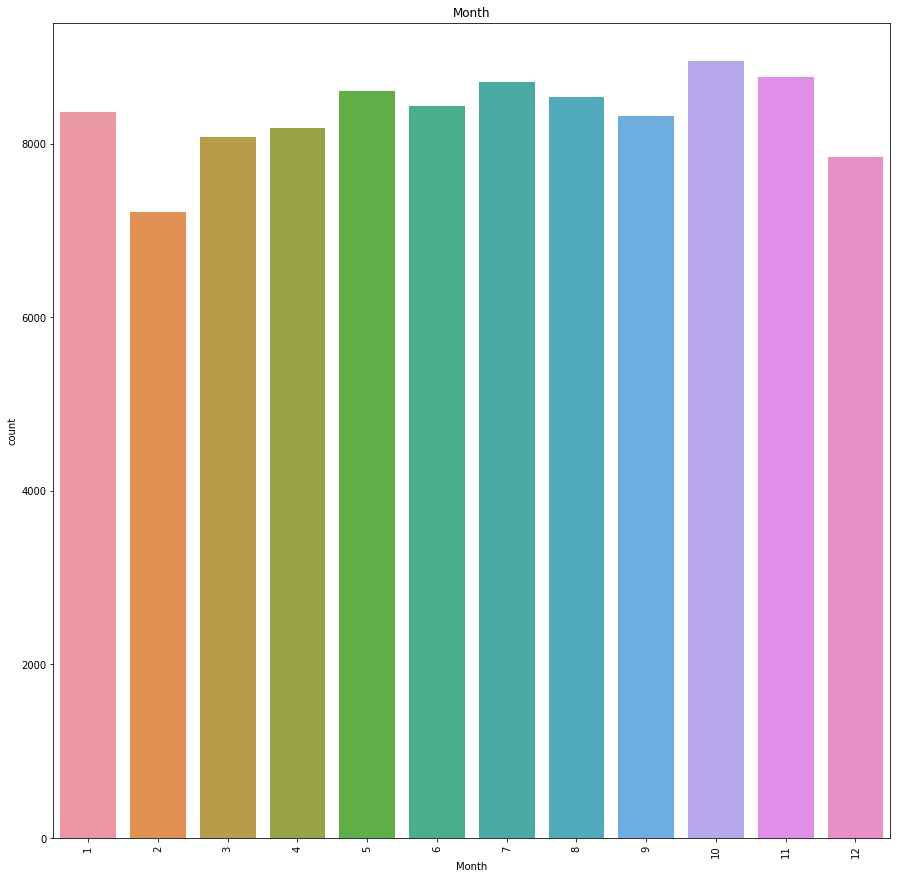

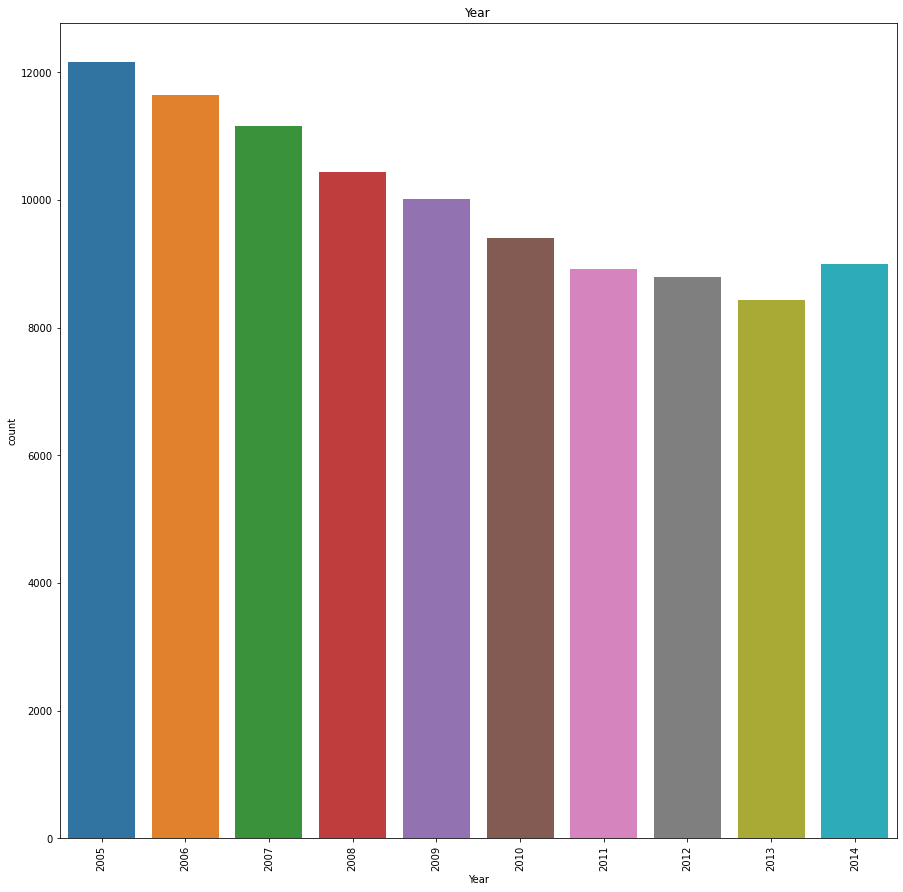

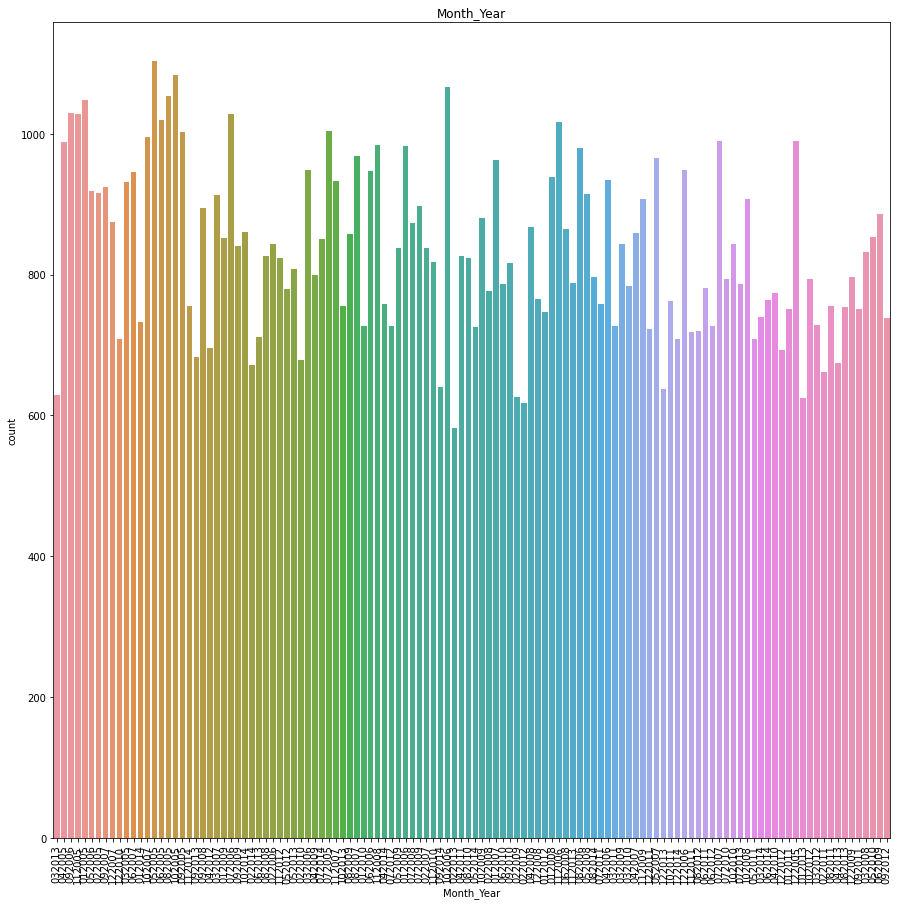

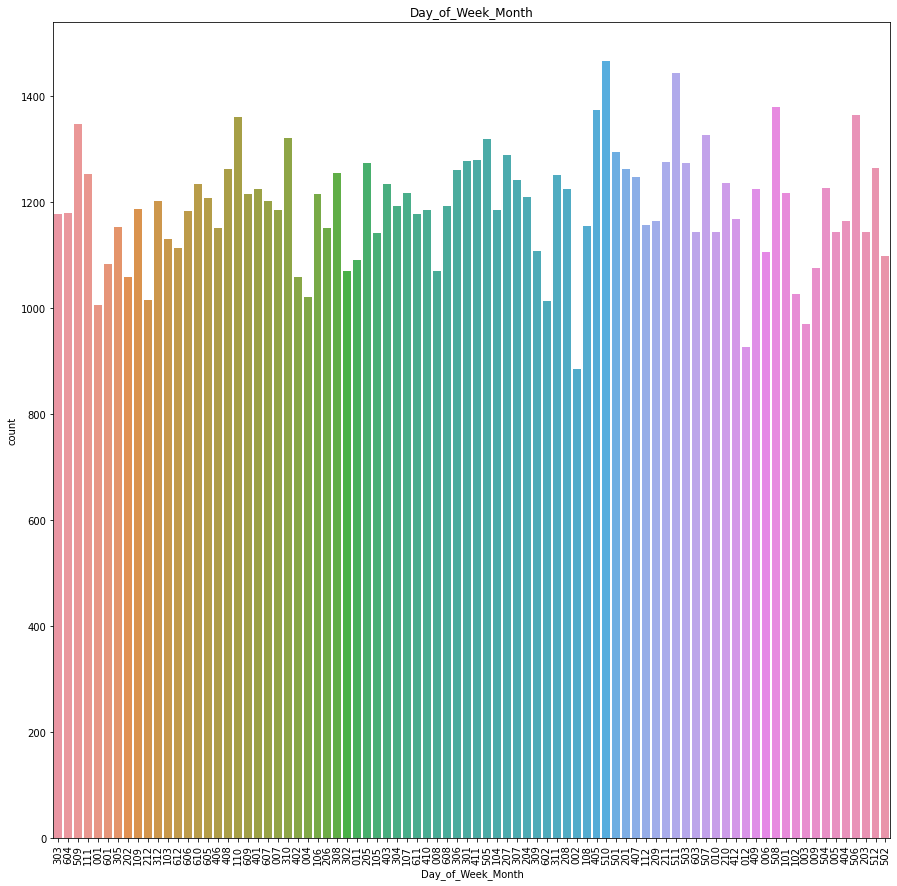

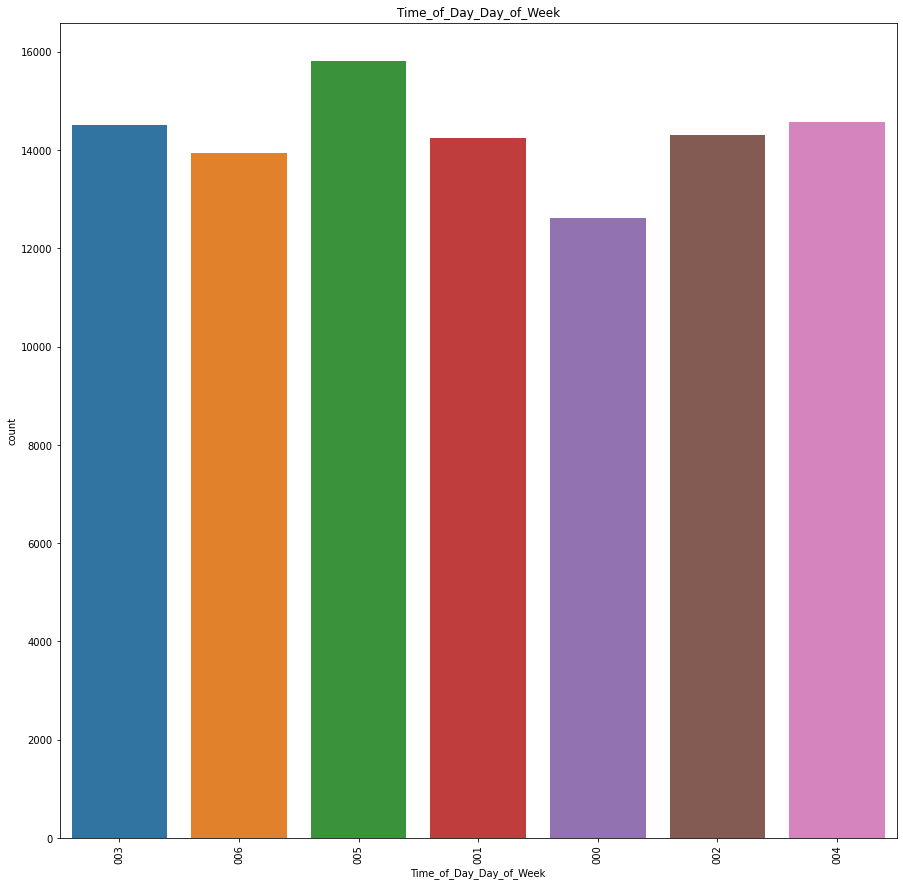

In [ ]:
time_features = ['Hour', 'Minute', 'Day_of_Week', 'Month', 'Year', 'Month_Year', 'Day_of_Week_Month', 'Time_of_Day_Day_of_Week']

# subplots of each time feature
for feature in time_features:
    plt.figure(figsize=(15,15))
    sns.countplot(x=feature, data=combined_samples)
    plt.xticks(rotation=90)
    plt.title(feature)
    plt.show()


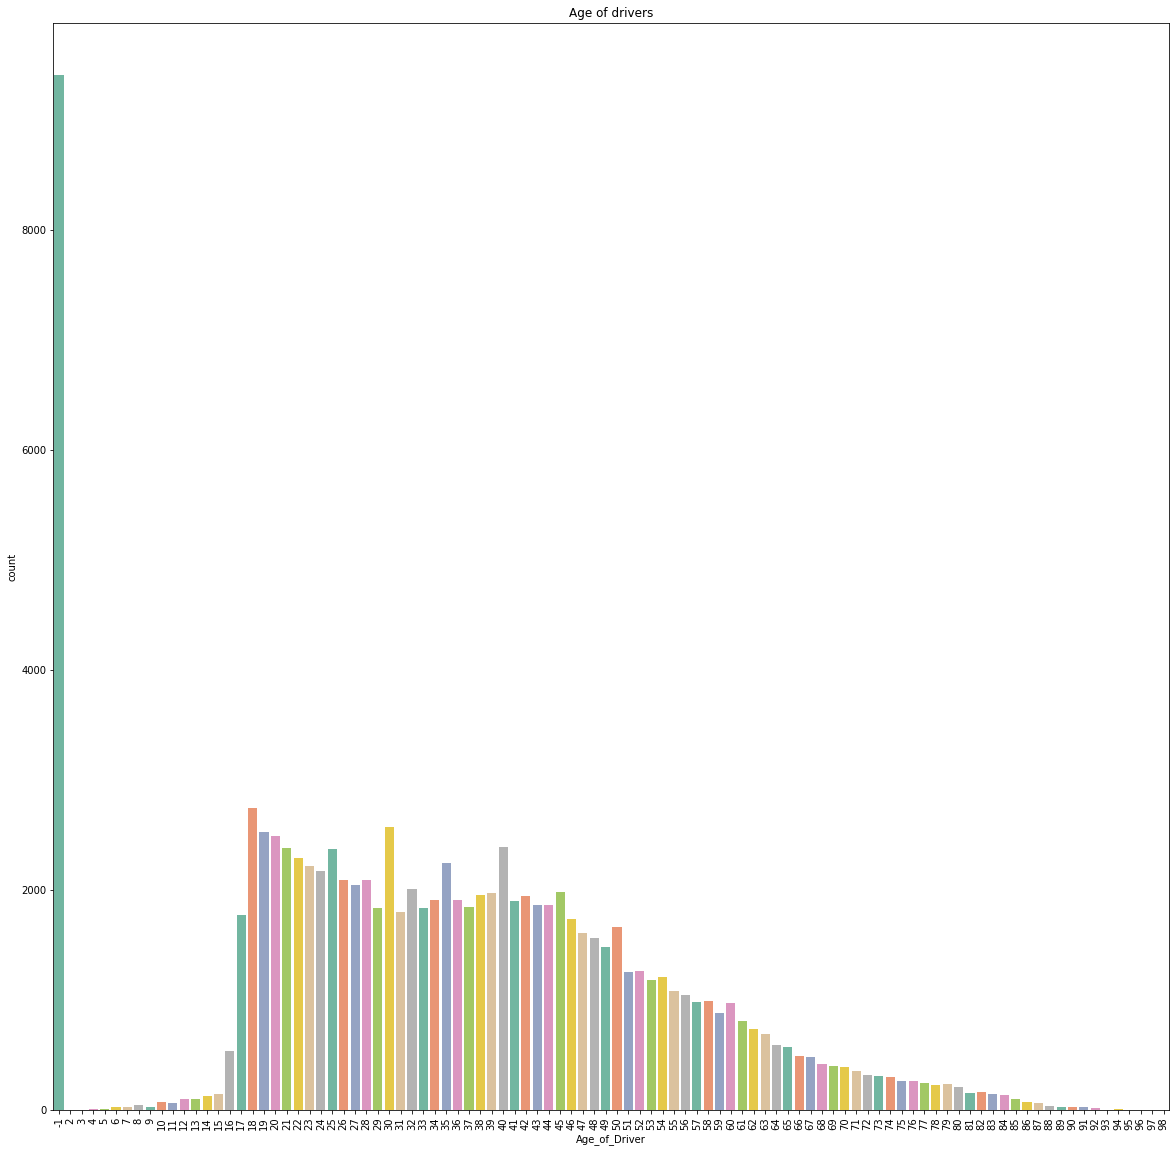

In [ ]:
# show age of drivers
plt.figure(figsize=(20,20))
sns.countplot(x='Age_of_Driver', data=combined_samples, palette='Set2')
plt.xticks(rotation=90)
plt.title('Age of drivers')
plt.show()

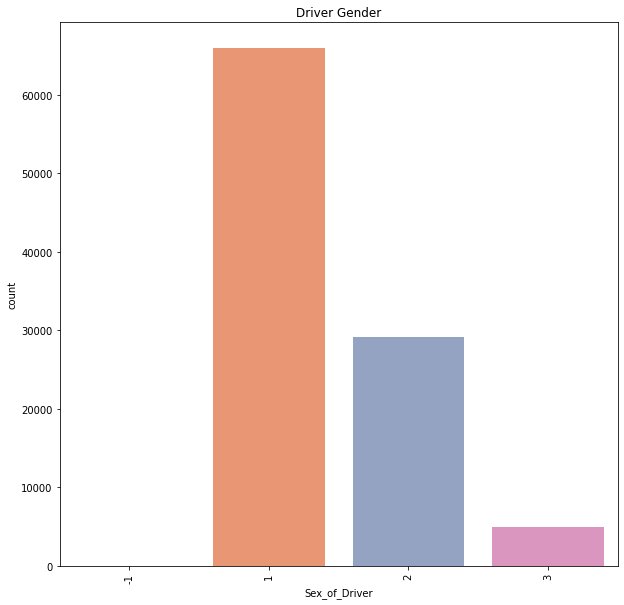

In [ ]:
# show age of drivers
# 1 - male, 2 -female, 3 unknown
plt.figure(figsize=(10,10))
sns.countplot(x='Sex_of_Driver', data=combined_samples, palette='Set2')
plt.xticks(rotation=90)
plt.title('Driver Gender')
plt.show()

In [ ]:
combined_samples.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Date,Day_of_Week,Time,Road_Type,Speed_limit,Junction_Detail,Junction_Control,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Vehicle_Reference_y,Vehicle_Type,Vehicle_Manoeuvre,Junction_Location,Skidding_and_Overturning,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Time_Num,Hour,Minute,Month,Year,Month_Year,Day_of_Week_Month,Time_of_Day_Day_of_Week
3732112,201332B200613,-0.080747,52.893457,3,2013-03-06,2,06:20,6,60,0,-1,1,1,1,2,1,1,1,1,22,3,0,0,0,0,0,9,3,1,9,13,0,2,9,1,1,1,22,5,13,3,620.0,6.0,20.0,3,2013,032013,303,003
341617,200542G027104,0.360810,51.580544,3,2005-04-30,5,13:30,1,60,1,4,1,1,1,2,1,1,1,1,62,3,0,0,0,0,-1,9,1,2,9,5,4,0,0,2,1,1,50,8,22,3,1330.0,13.0,30.0,4,2005,042005,604,006
940547,200650F52M614,-3.795670,50.444267,3,2006-09-29,4,13:10,3,70,0,0,1,2,2,2,1,1,1,2,79,3,0,0,0,0,-1,9,1,2,9,17,-1,0,0,1,-1,1,18,4,3,1,1310.0,13.0,10.0,9,2006,092006,509,005
234572,2005215438099,-1.721512,52.645624,3,2005-11-28,0,16:05,6,40,3,4,4,3,2,1,2,2,2,2,13,3,0,0,2,0,-1,9,3,2,9,18,8,0,0,1,1,1,40,7,5,3,1605.0,16.0,5.0,11,2005,112005,111,001
5061,200501EO40004,-0.175630,51.560796,3,2005-01-02,6,09:15,6,30,6,4,1,1,2,1,2,1,1,1,-1,3,0,0,0,0,-1,1,-1,1,9,7,8,0,0,1,1,1,64,9,15,-1,915.0,9.0,15.0,1,2005,012005,001,000


In [22]:
# Drop columns for TSNE, since they are not numeric
combined_samples_numeric = combined_samples.drop(['Accident_Index', 'Date', 'Time'], axis=1)

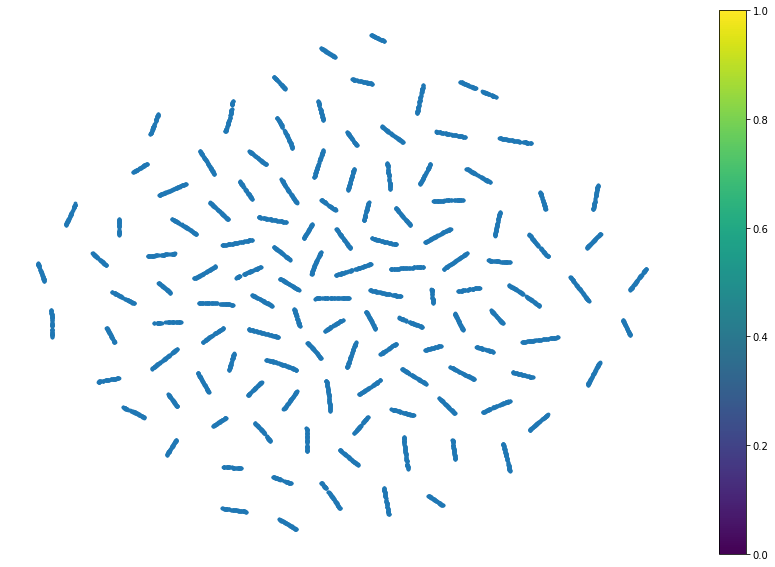

In [23]:
m = 10000
X_reduced = PCA(n_components=0.95).fit_transform(combined_samples_numeric[:10000]) # TODO: use PCA to keep 95% of explained variance in X_viz
viz = TSNE(n_components=2, random_state=42, learning_rate='auto', init='random', n_jobs=-1).fit_transform(X_reduced)
plt.figure(figsize=(15,10))
plt.scatter(viz[:, 0], viz[:, 1], cmap='cool', s=8)
plt.axis('off')
plt.colorbar()

In [19]:
pd.set_option('display.max_rows', 20)
combined_samples.isnull().sum().sort_values(ascending=False)

LSOA_of_Accident_Location    240311
Time                            226
Minute                          226
Hour                            226
Time_Num                        226
                              ...  
Casualty_Class                    0
Sex_of_Casualty                   0
Age_of_Casualty                   0
Age_Band_of_Casualty              0
Time_of_Day_Day_of_Week           0
Length: 74, dtype: int64

In [25]:
X_train.dropna(subset=['Longitude', 'Latitude'],axis=0)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Vehicle_Reference_y,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Time_Num,Hour,Minute,Month,Year,Month_Year,Day_of_Week_Month,Time_of_Day_Day_of_Week
3851442,201350GT3F032,174717.0,46931.0,-5.163452,50.279182,50,3,4,4,2013-11-10,6,14:00,596,E06000052,3,30,1,60,1,4,3,390,0,0,1,1,1,0,0,1,E01018820,2,3,2,2,67,10,3,0,0,1,0,0,9,1,3,9,0,18,0,8,0,0,0,0,1,1,6,2,37,7,-1,-1,-1,5,3,1400.0,14.0,0.0,11,2013,112013,011,000
3023594,20114100G0416,517030.0,228550.0,-0.298814,51.943106,41,2,1,3,2011-08-19,4,20:31,433,E10000015,3,505,3,50,0,-1,-1,0,0,0,6,1,1,0,0,1,E01023615,1,1,1,1,20,4,3,0,0,0,0,0,9,1,1,9,0,18,0,0,2,0,1,9,1,1,6,1,20,4,1360,1,10,6,1,2031.0,20.0,31.0,8,2011,082011,508,005
1491833,2007960700755,253770.0,694430.0,-4.353745,56.120198,96,2,1,1,2007-03-13,1,08:30,939,S12000030,4,835,6,60,0,-1,-1,0,0,0,1,1,2,0,0,1,NaN,1,1,1,1,35,6,2,0,0,0,0,-1,9,1,1,9,0,17,0,0,2,0,7,10,1,1,1,1,35,6,1461,2,2,-1,1,830.0,8.0,30.0,3,2007,032007,203,002
1657707,200814A093108,456600.0,398270.0,-1.148634,53.478110,14,3,2,7,2008-01-05,5,06:30,211,E08000017,2,1,1,70,1,4,1,18,0,0,1,1,1,0,0,1,E01007611,2,6,2,1,50,8,3,0,0,0,0,-1,10,1,2,10,0,10,0,8,0,0,0,0,3,1,1,1,48,8,2402,2,4,3,1,630.0,6.0,30.0,1,2008,012008,601,006
458140,200554AY53905,416920.0,123990.0,-1.760188,51.014982,54,2,2,1,2005-07-10,6,07:57,632,E06000054,3,338,6,60,0,-1,-1,0,0,0,1,8,1,0,0,1,E01031995,2,1,1,2,39,7,2,0,0,0,0,-1,1,3,1,9,0,18,0,0,0,0,0,0,1,1,1,1,31,6,1598,1,9,5,1,757.0,7.0,57.0,7,2005,072005,007,000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044887,201414C130514,443901.0,400902.0,-1.339597,53.502977,14,3,2,1,2014-09-12,4,16:26,213,E08000018,3,633,1,30,1,4,6,0,0,0,4,1,1,0,0,1,E01007820,1,1,2,1,24,5,3,0,0,1,0,0,9,1,2,9,0,18,0,5,0,0,0,0,4,1,6,1,57,9,1364,1,5,3,1,1626.0,16.0,26.0,9,2014,092014,509,005
1136074,2007070420039,389780.0,379260.0,-2.154854,53.310166,7,3,2,2,2007-12-16,6,17:03,126,E06000049,4,5358,6,60,0,0,-1,0,0,0,6,1,2,0,0,1,E01018667,2,2,1,2,41,7,3,0,0,0,0,-1,9,2,1,9,0,16,0,0,1,0,0,0,1,1,15,2,21,5,1595,1,10,10,1,1703.0,17.0,3.0,12,2007,122007,012,000
1570006,200804DF08026,354750.0,431510.0,-2.688151,53.777942,4,3,4,3,2008-06-02,0,15:20,79,E10000017,6,0,6,30,3,4,6,0,0,5,1,1,1,0,0,1,E01025243,2,1,1,1,18,4,3,0,0,0,0,-1,9,1,4,9,0,3,0,2,0,0,0,0,4,1,15,2,74,10,1896,2,2,3,1,1520.0,15.0,20.0,6,2008,062008,106,001
2234489,200943N171109,484530.0,213260.0,-0.775241,51.811546,43,3,2,3,2009-10-20,1,14:08,476,E10000002,3,41,1,30,2,4,6,2044,0,0,1,1,1,0,0,1,E01017700,2,1,1,1,55,8,3,0,0,0,0,-1,11,2,1,9,0,16,0,3,0,0,0,0

## Summary

We chose sampling sizes of 100,000 so that we could get a good amount of random samples to do visualization with, for the sake of time. We also found that many of the columns were irrelevant in finding the solution to our client's problem, so we dropped them. We used the lattitude and longitude data in order to create a plot map, so that we could look at the data related by area, to get a better idea of where the accidents were happening, and what factors contributed to them. ...

# Prepare The Data

In [14]:
X_train

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Vehicle_Reference_y,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Time_Num,Hour,Minute,Month,Year,Month_Year,Day_of_Week_Month,Time_of_Day_Day_of_Week
3851442,201350GT3F032,174717.0,46931.0,-5.163452,50.279182,50,3,4,4,2013-11-10,6,14:00,596,E06000052,3,30,1,60,1,4,3,390,0,0,1,1,1,0,0,1,E01018820,2,3,2,2,67,10,3,0,0,1,0,0,9,1,3,9,0,18,0,8,0,0,0,0,1,1,6,2,37,7,-1,-1,-1,5,3,1400.0,14.0,0.0,11,2013,112013,011,000
3023594,20114100G0416,517030.0,228550.0,-0.298814,51.943106,41,2,1,3,2011-08-19,4,20:31,433,E10000015,3,505,3,50,0,-1,-1,0,0,0,6,1,1,0,0,1,E01023615,1,1,1,1,20,4,3,0,0,0,0,0,9,1,1,9,0,18,0,0,2,0,1,9,1,1,6,1,20,4,1360,1,10,6,1,2031.0,20.0,31.0,8,2011,082011,508,005
1491833,2007960700755,253770.0,694430.0,-4.353745,56.120198,96,2,1,1,2007-03-13,1,08:30,939,S12000030,4,835,6,60,0,-1,-1,0,0,0,1,1,2,0,0,1,NaN,1,1,1,1,35,6,2,0,0,0,0,-1,9,1,1,9,0,17,0,0,2,0,7,10,1,1,1,1,35,6,1461,2,2,-1,1,830.0,8.0,30.0,3,2007,032007,203,002
1657707,200814A093108,456600.0,398270.0,-1.148634,53.478110,14,3,2,7,2008-01-05,5,06:30,211,E08000017,2,1,1,70,1,4,1,18,0,0,1,1,1,0,0,1,E01007611,2,6,2,1,50,8,3,0,0,0,0,-1,10,1,2,10,0,10,0,8,0,0,0,0,3,1,1,1,48,8,2402,2,4,3,1,630.0,6.0,30.0,1,2008,012008,601,006
458140,200554AY53905,416920.0,123990.0,-1.760188,51.014982,54,2,2,1,2005-07-10,6,07:57,632,E06000054,3,338,6,60,0,-1,-1,0,0,0,1,8,1,0,0,1,E01031995,2,1,1,2,39,7,2,0,0,0,0,-1,1,3,1,9,0,18,0,0,0,0,0,0,1,1,1,1,31,6,1598,1,9,5,1,757.0,7.0,57.0,7,2005,072005,007,000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044887,201414C130514,443901.0,400902.0,-1.339597,53.502977,14,3,2,1,2014-09-12,4,16:26,213,E08000018,3,633,1,30,1,4,6,0,0,0,4,1,1,0,0,1,E01007820,1,1,2,1,24,5,3,0,0,1,0,0,9,1,2,9,0,18,0,5,0,0,0,0,4,1,6,1,57,9,1364,1,5,3,1,1626.0,16.0,26.0,9,2014,092014,509,005
1136074,2007070420039,389780.0,379260.0,-2.154854,53.310166,7,3,2,2,2007-12-16,6,17:03,126,E06000049,4,5358,6,60,0,0,-1,0,0,0,6,1,2,0,0,1,E01018667,2,2,1,2,41,7,3,0,0,0,0,-1,9,2,1,9,0,16,0,0,1,0,0,0,1,1,15,2,21,5,1595,1,10,10,1,1703.0,17.0,3.0,12,2007,122007,012,000
1570006,200804DF08026,354750.0,431510.0,-2.688151,53.777942,4,3,4,3,2008-06-02,0,15:20,79,E10000017,6,0,6,30,3,4,6,0,0,5,1,1,1,0,0,1,E01025243,2,1,1,1,18,4,3,0,0,0,0,-1,9,1,4,9,0,3,0,2,0,0,0,0,4,1,15,2,74,10,1896,2,2,3,1,1520.0,15.0,20.0,6,2008,062008,106,001
2234489,200943N171109,484530.0,213260.0,-0.775241,51.811546,43,3,2,3,2009-10-20,1,14:08,476,E10000002,3,41,1,30,2,4,6,2044,0,0,1,1,1,0,0,1,E01017700,2,1,1,1,55,8,3,0,0,0,0,-1,11,2,1,9,0,16,0,3,0,0,0,0

In [45]:
y_train.shape

(643139, 74)

In [9]:
# The preprocessing pipeline that will remove irrelevant features, scale the data, and do PCA on it. 
preprocessor = Pipeline([
    ('drop_pipeline', NumpyArrayToPandasDataFrame(ColumnTransformer([
        ('drop_irrelevant', 'drop', [
                                    'Accident_Index', 'LSOA_of_Accident_Location', 'Did_Police_Officer_Attend_Scene_of_Accident',
                                    'Carriageway_Hazards', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
                                    'Police_Force', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
                                    '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
                                    '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
                                    'Special_Conditions_at_Site', 'Number_of_Vehicles', 'Number_of_Casualties',
                                    'Engine_Capacity_(CC)', 'Propulsion_Code', 'Driver_IMD_Decile',
                                    'Towing_and_Articulation', 'Journey_Purpose_of_Driver', 'Vehicle_Location-Restricted_Lane',
                                    'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Time', 'Date'
        ]),
    ], remainder='passthrough'))),
    ('drop_nans', DropNaNs(['Longitude', 'Latitude'])),
    # ('remove_negatives', RemoveNegatives()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
]).fit(X_train, y_train)

ValueError: Shape of passed values is (3594229, 46), indices imply (3594229, 74)

# Short-List Promising Models

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = Pipeline(steps=[
('preprocessor', preprocessor),
('SGD_Classifier', SGDClassifier())
])
sgd.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, sgd.predict(X)), cross_val_score(sgd, X, y, scoring='accuracy', cv=3)

y_pred_sgd = cross_val_predict(sgd, X, y)
accuracy_radius = accuracy_score(y, y_pred_sgd)
metric_radius = precision_score(y, y_pred_sgd)
accuracy_radius, metric_radius

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc= Pipeline(steps=[
('preprocessor', preprocessor),
('DecisionTreeClassifier', DecisionTreeClassifier()),
])
dtc.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, dtc.predict(X)), cross_val_score(dtc, X, y, scoring='accuracy', cv=3)

y_pred_decision = cross_val_predict(dtc, X, y)
accuracy_radius = accuracy_score(y, y_pred_decision)
metric_radius = precision_score(y, y_pred_decision)
accuracy_radius, metric_radius

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline(steps=[
('preprocessor', preprocessor),
('RandomTree_Classifier', RandomForestClassifier())
])

rfc.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, rfc.predict(X)), cross_val_score(rfc, X, y, scoring='accuracy', cv=3)

y_pred_random = cross_val_predict(rfc, X, y)
accuracy_radius = accuracy_score(y, y_pred_random)
metric_radius = precision_score(y, y_pred_random)
accuracy_radius, metric_radius

In [ ]:
from sklearn.svm import SVC
svm = Pipeline(steps=[
('preprocessor', preprocessor),
('SVC', SVC())
])

rfc.fit(X, y)

# Show the training and generalation accuracies
accuracy_score(y, svm.predict(X)), cross_val_score(svm, X, y, scoring='accuracy', cv=3)

y_pred_random = cross_val_predict(svm, X, y)
accuracy_radius = accuracy_score(y, y_pred_random)
metric_radius = precision_score(y, y_pred_random)
accuracy_radius, metric_radius

In [ ]:
from tensorflow import keras
# TODO: Create the model and show the summary
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train[0].shape))
model.add(keras.layers.Dense(300, activation=keras.activations.relu, name="hidden-1"))
model.add(keras.layers.Dense(100, activation=keras.activations.relu, name="hidden-2"))
model.add(keras.layers.Dense(10, activation=keras.activations.softmax, name="output"))
model.summary()

In [ ]:
# TODO: Compile the model
model.compile(optimizer="sgd", metrics=["accuracy"], loss="sparse_categorical_crossentropy")

In [ ]:
# TODO: Fit the model to the training data
# Complete 20 epochs and show the validation scores
# Save the history (the return value) to a variable
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Fine-Tune The System

# Present Your Solution